# tf -> tflite 만들기

In [72]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [73]:
import numpy as np 
from tensorflow import keras
import matplotlib.pyplot as plt
import math


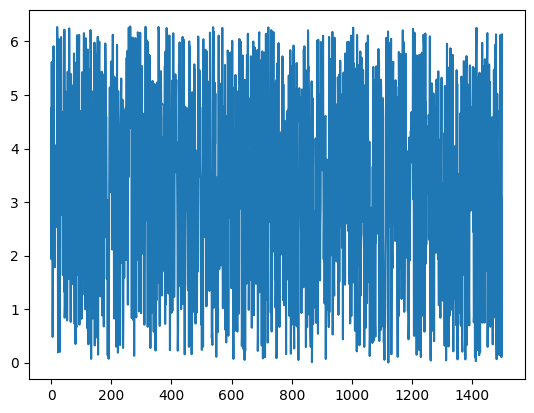

In [74]:
#사인파 생성 , random , seed
SAMPLES = 1500

np.random.seed(786)
tf.random.set_seed(786)

x_value = np.random.uniform(low = 0, high = 2*math.pi, size = SAMPLES)
plt.plot(x_value)
plt.show()

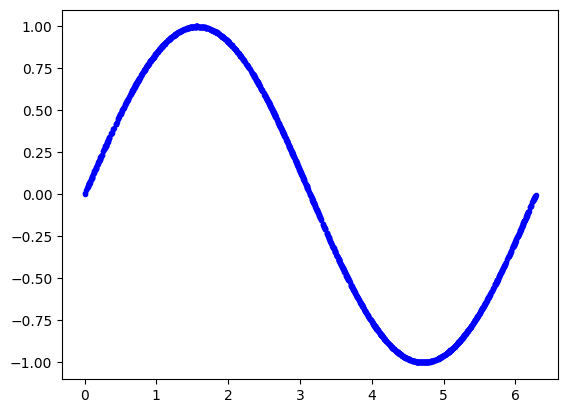

In [75]:
# x_value 통해서 y_value값 샘플
np.random.shuffle(x_value)
y_value = np.sin(x_value)

plt.plot(x_value, y_value, 'b.')
plt.show() 

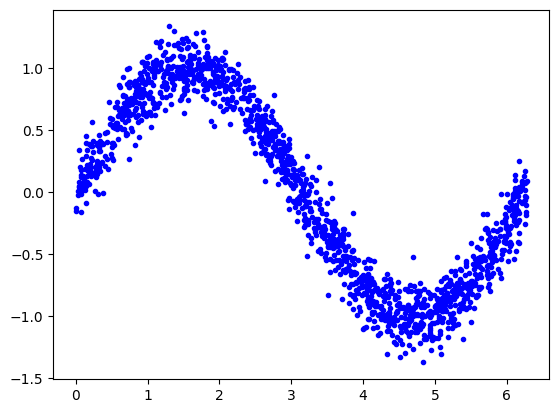

In [99]:
#노이즈

y_value = y_value + 0.1*np.random.randn(*y_value.shape)
plt.plot(x_value, y_value, 'b.')
plt.show() 

900 300 300


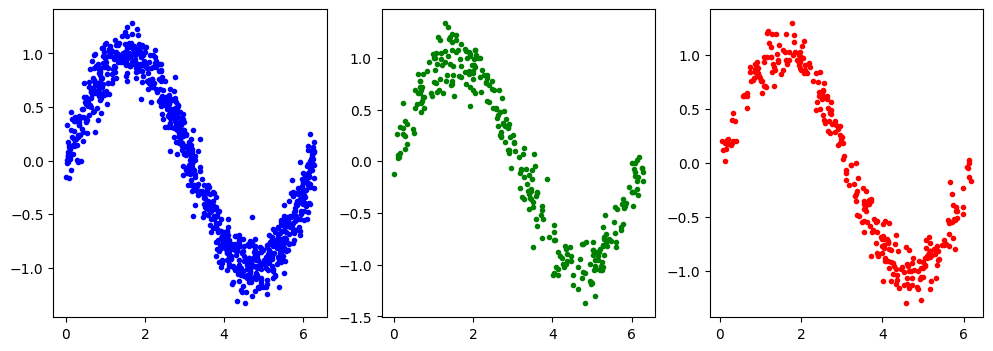

In [100]:
# train 60%
# validation 20%
# test 20%

TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES)
VALIDATION_SPLIT = int(0.2 * SAMPLES)

x_train, x_test, x_validation = np.split(x_value, [TRAIN_SPLIT, TEST_SPLIT*4])
print(len(x_train), len(x_test), len(x_validation))

y_train, y_test, y_validation = np.split(y_value,[TRAIN_SPLIT, TEST_SPLIT*4])

fig = plt.figure(figsize = (12, 4))
ax1 = fig.add_subplot(1, 3, 1)
plt.plot(x_train, y_train, 'b.', label = "Train")

ax2 = fig.add_subplot(1, 3, 2)
plt.plot(x_validation, y_validation, 'g.', label = "validation")

ax3 = fig.add_subplot(1, 3, 3)
plt.plot(x_test, y_test, 'r.', label = "Test")


In [102]:
# 모델을 생성, 컴파일
model = tf.keras.Sequential()

model.add(keras.layers.Dense(16, activation = 'relu', input_shape = (1, )))
model.add(keras.layers.Dense(16, activation = 'relu'))
model.add(keras.layers.Dense(1))

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 16)                32        
                                                                 
 dense_20 (Dense)            (None, 16)                272       
                                                                 
 dense_21 (Dense)            (None, 1)                 17        
                                                                 
Total params: 321 (1.25 KB)
Trainable params: 321 (1.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [103]:
train_info = model.fit(
    x_train,
    y_train,
    epochs = 350,
    batch_size = 64,
    validation_data = (x_validation, y_validation)
)

Epoch 1/350
15/15 [==============================] - 1s 13ms/step - loss: 0.9234 - mae: 0.8318 - val_loss: 0.6196 - val_mae: 0.7045
Epoch 2/350
15/15 [==============================] - 0s 5ms/step - loss: 0.4864 - mae: 0.6170 - val_loss: 0.5276 - val_mae: 0.6314
Epoch 3/350
15/15 [==============================] - 0s 5ms/step - loss: 0.4301 - mae: 0.5614 - val_loss: 0.5179 - val_mae: 0.6181
Epoch 4/350
15/15 [==============================] - 0s 4ms/step - loss: 0.4156 - mae: 0.5470 - val_loss: 0.4963 - val_mae: 0.6056
Epoch 5/350
15/15 [==============================] - 0s 4ms/step - loss: 0.3966 - mae: 0.5366 - val_loss: 0.4708 - val_mae: 0.5917
Epoch 6/350
15/15 [==============================] - 0s 4ms/step - loss: 0.3785 - mae: 0.5263 - val_loss: 0.4505 - val_mae: 0.5795
Epoch 7/350
15/15 [==============================] - 0s 4ms/step - loss: 0.3635 - mae: 0.5171 - val_loss: 0.4311 - val_mae: 0.5678
Epoch 8/350
15/15 [==============================] - 0s 5ms/step - loss: 0.3486 - 

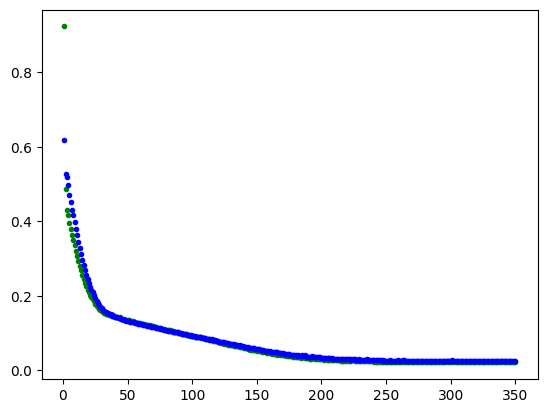

In [105]:
loss = train_info.history['loss']
validation_loss = train_info.history['val_loss']

epochs_list = range(1, 350+1)

plt.plot(epochs_list, loss, 'g.', label = 'Train loss')
plt.plot(epochs_list, validation_loss, 'b.', label = 'Validation loss')

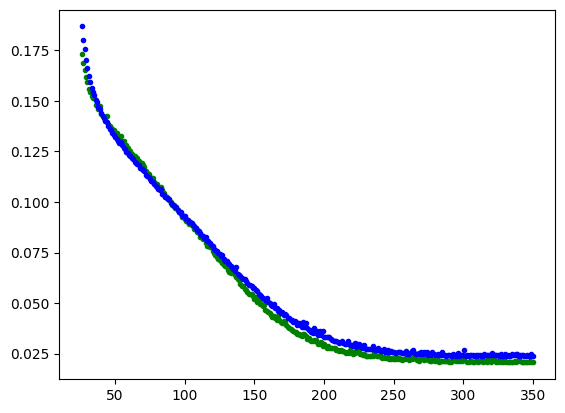

In [110]:
SKIP = 25

plt.plot(epochs_list[SKIP:], loss[SKIP:], 'g.', label = 'Train loss')
plt.plot(epochs_list[SKIP:], validation_loss[SKIP:], 'b.', label = 'Validation loss')

10/10 [==============================] - 0s 2ms/step


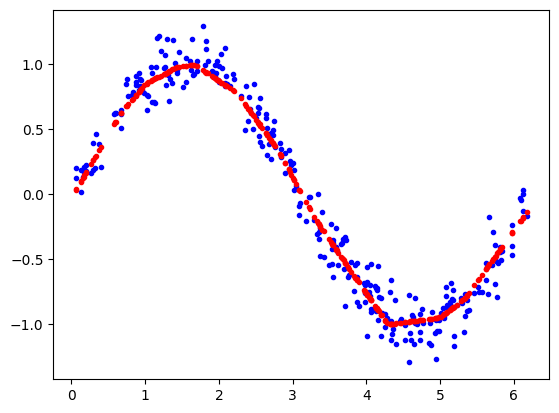

In [112]:
loss = model.evaluate(x_test, y_test)

preditions = model.predict(x_test)

plt.clf()
plt.plot(x_test, y_test, 'b.', label = 'Actual')
plt.plot(x_test, preditions, 'r.', label = 'Predicted')
plt.show()

In [114]:
# TFlite convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

#save
open("sinewave_model.tflite", "wb").write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpks5_w29i\assets


INFO:tensorflow:Assets written to: C:\Users\Public\Documents\ESTsoft\CreatorTemp\tmpks5_w29i\assets


3236

In [115]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source, header = convert_bytes_to_c_source(
    tflite_model,
    "sine_model",
    include_path = "sine_model.h"
)

with open('sine_model.h', 'w') as file:
    file.write(header)

with open('sine_model.cpp', 'w') as file:
    file.write(source)